
# time-series-project

1. Install yahoo finance library (yfinance)
2. Retrieve stock price data
3. Choose any ticker symbol and you can choose “Open” or “Close” price for this project<sup>[1](#myfootnote1)</sup> <sup>[2](#myfootnote2)</sup>
4. Analyse time series<sup>[3](#myfootnote3)</sup>
5. Check for seasonality
6. Train time series model
7. Find the best hyperparameter values of (P, D, Q) with the smallest RMSE for building an ARIMA model<sup>[4](#myfootnote4)</sup>
8. Predict price for the next time period (Maybe two Timestamps)
9. Save timestamp, prediction and actual price to a database

❗ BONUS: Deploy your model to Streamlit.  
a. The app should pull fresh data from the web through yfinance  
b. The user should be able to define a forecasting window (how far ahead they want the forecast)  

❗❗ Extra Super Hard BONUS!! Allow the user to choose the ticker symbol to look up and get predictions for.   
HINT: you'll need to refit the model. This may be hard without determining again the P, D, and Q

<a name="myfootnote1">1</a>: The program should only run between 8am and 4pm ET  
<a name="myfootnote2">2</a>: The data period and interval should be 1 year and 1 hour respectively  
<a name="myfootnote3">3</a>: Choose the last 50 records as your test data for the purpose of saving time  
<a name="myfootnote4">4</a>: Please set the hyperparameter values of (P, D, Q) within these ranges also for the purpose of saving time: For “P”: 1 ≦ P ≦ 3 For “D”: 0 ≦ D ≦ 2 For “Q”: 0 ≦ Q ≦ 2


In [35]:
# Base Imports

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats='retina'

plt.style.use("tableau-colorblind10")

import numpy as np
import pandas as pd

import warnings


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.simplefilter("ignore", InterpolationWarning)

from sklearn.preprocessing import power_transform
from sklearn import set_config

set_config(transform_output="pandas")

# ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:
# Null Hypothesis: The series has a unit root.
# Alternate Hypothesis: The series has no unit root.
# If the null hypothesis fails to be rejected, this test may provide evidence that the series is non-stationary.
def adf_test(timeseries, autolag="AIC"):
    from statsmodels.tsa.stattools import adfuller

    # "AIC" (Akaike Information Criterion):
    # This option selects the lag length that minimizes the AIC.
    # The AIC is a measure that balances the goodness of fit of a statistical model with its complexity.
    # Lower AIC values generally indicate a better model.
    # "BIC" (Bayesian Information Criterion):
    # Similar to AIC, this option chooses the lag length that minimizes the BIC.
    # The BIC also balances model fit and complexity, but it tends to penalize complex models more heavily than the AIC.
    # "t-stat" (t-statistic):
    # This method starts with the maximum lag length (maxlag) and iteratively reduces it.
    # It stops when the t-statistic of the last lag becomes statistically significant (typically at a 5% significance level).
    # This approach focuses on the statistical significance of the individual lags.
    dftest = adfuller(timeseries.dropna(), autolag=autolag)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput[autolag] = dftest[5]

    dfoutput.name = "Results of Dickey-Fuller Test"

    if (dftest[1] < 0.05) & (dftest[4]["5%"] > dftest[0]):
        print(
            "\u001b[32mConclusion: The data is stationary (Reject the null hypothesis)\u001b[0m"
        )
    else:
        print(
            "\x1b[31mConclusion: The data is not stationary (Fail to reject the null hypothesis)\x1b[0m"
        )
    return dfoutput


# KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
# Null Hypothesis: The process is trend stationary.
# Alternate Hypothesis: The series has a unit root (series is not stationary).
def kpss_test(timeseries, regression="c"):
    from statsmodels.tsa.stattools import kpss

    kpsstest = kpss(timeseries.dropna(), regression=regression, nlags="auto")
    kpssoutput = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpssoutput["Critical Value (%s)" % key] = value

    kpssoutput.name = "Results of KPSS Test"

    if (kpsstest[1] < 0.05) & (kpsstest[3]["5%"] > kpsstest[0]):
        print(
            "\x1b[31mConclusion: The data is not stationary (Reject the null hypothesis)\x1b[0m"
        )

    else:
        print(
            "\u001b[32mConclusion: The data is stationary (Fail to reject the null hypothesis)\u001b[0m"
        )

    return kpssoutput

def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)


In [2]:
# Install yahoo finance library (yfinance)
# %conda install yfinance

import yfinance as yf
import os

# Define the cache directory path
cache_dir = os.path.expanduser("~/.yfinance_cache")

# Create the directory if it doesn't exist
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Set the cache location
yf.set_tz_cache_location(cache_dir)

# # Now you can use yfinance functions
# dat = yf.Ticker("MSFT")
# dat.info
# dat.calendar
# dat.analyst_price_targets
# dat.quarterly_income_stmt
# dat.history(period='1mo')
# dat.option_chain(dat.options[0]).calls

In [ ]:
# Retrieve stock price data
# Choose any ticker symbol and you can choose “Open” or “Close” price for this project

# hoping to build model for
# tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JNJ', 'XOM', 'V', 'WMT', 'NVDA', 'PG',
#             'LLY', 'CVX', 'MA', 'HD', 'PFE', 'ABBV', 'MRK', 'KO', 'PEP', 'AVGO', 'ORCL',
#             'TMO', 'AZN', 'CSCO', 'DHR', 'MCD', 'ABT', 'TMUS', 'ACN', 'NEE', 'VZ', 'TTE',
#             'LIN', 'DIS', 'PM', 'BMY', 'CMCSA', 'SCHW', 'UPS', 'TXN', 'RTX', 'COP']
# will start with 'AAPl'

import datetime as dt

tickers = ["AAPL"]


yf_dl = yf.download(
    tickers,
    start=None,
    end=None,
    actions=False,
    threads=True,
    ignore_tz=None,
    group_by="column",
    auto_adjust=True,
    back_adjust=False,
    repair=False,
    keepna=False,
    progress=True,
    period="1y",
    interval="1h",
    prepost=False,
    proxy=None,
    rounding=False,
    timeout=10,
    session=None,
    multi_level_index=False,
)
yf_dl

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Datetime,,,,,
2024-04-03 18:30:00+00:00,169.524994,170.600006,169.279999,170.199997,0
2024-04-03 19:30:00+00:00,169.660004,170.149994,169.380005,169.529999,6602092
2024-04-04 13:30:00+00:00,171.009995,171.190002,170.039993,170.289993,9047827
2024-04-04 14:30:00+00:00,171.270004,171.279999,170.710007,171.014999,4545243
2024-04-04 15:30:00+00:00,171.720306,171.919998,171.274994,171.279999,4325890
...,...,...,...,...,...
2025-04-03 14:30:00+00:00,204.050003,206.360001,203.369995,205.634995,11492280
2025-04-03 15:30:00+00:00,206.059998,207.039993,203.704300,204.050003,8453124
2025-04-03 16:30:00+00:00,204.005005,206.300003,203.840103,206.100006,5727160


In [ ]:
# Analyse time series

# from pandas.tseries.offsets import Minute
# fifteen_min = Minute(n=15)

yf_dl = yf_dl.resample("h").sum() # resample by hour
yf_dl.index.freq = "h"
yf_dl

,Close,High,Low,Open,Volume
Datetime,,,,,
2024-04-03 18:00:00+00:00,169.524994,170.600006,169.279999,170.199997,0
2024-04-03 19:00:00+00:00,169.660004,170.149994,169.380005,169.529999,6602092
2024-04-03 20:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0
2024-04-03 21:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0
2024-04-03 22:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...
2025-04-03 14:00:00+00:00,204.050003,206.360001,203.369995,205.634995,11492280
2025-04-03 15:00:00+00:00,206.059998,207.039993,203.704300,204.050003,8453124
2025-04-03 16:00:00+00:00,204.005005,206.300003,203.840103,206.100006,5727160


In [17]:
adf_test(yf_dl["Close"])

Conclusion: The data is stationary (Reject the null hypothesis)


Test Statistic                -1.251653e+01
p-value                        2.604063e-23
#Lags Used                     3.500000e+01
Number of Observations Used    8.725000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
AIC                            8.293942e+04
Name: Results of Dickey-Fuller Test, dtype: float64

Conclusion: The data is stationary (Reject the null hypothesis)


35.0

In [18]:
kpss_test(yf_dl["Close"])

Conclusion: The data is stationary (Fail to reject the null hypothesis)


Test Statistic            0.378541
p-value                   0.086405
Lags Used                26.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Name: Results of KPSS Test, dtype: float64

In [36]:
adf_lags_used = adf_test(yf_dl["Close"]).iloc[2] # lags used by ADF test
adf_lags_used += 1 # need to add lag 0 to complete the period
period = adf_lags_used.astype(int) # convert to int
period

Conclusion: The data is stationary (Reject the null hypothesis)


36

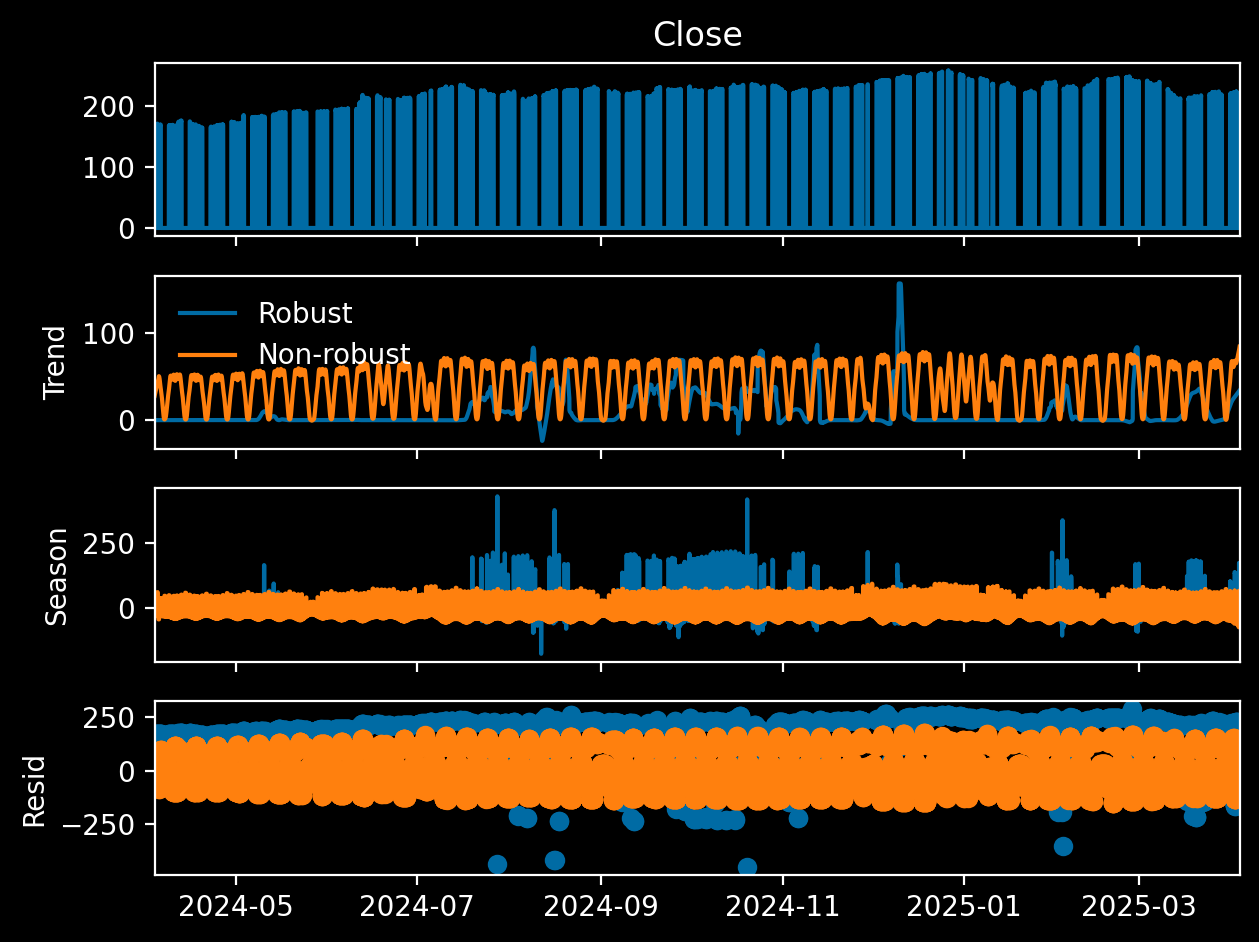

In [37]:
from statsmodels.tsa.seasonal import STL

stl = STL(yf_dl["Close"].dropna(), period=period, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(yf_dl["Close"].dropna(), period=period, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

159 ms ± 629 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


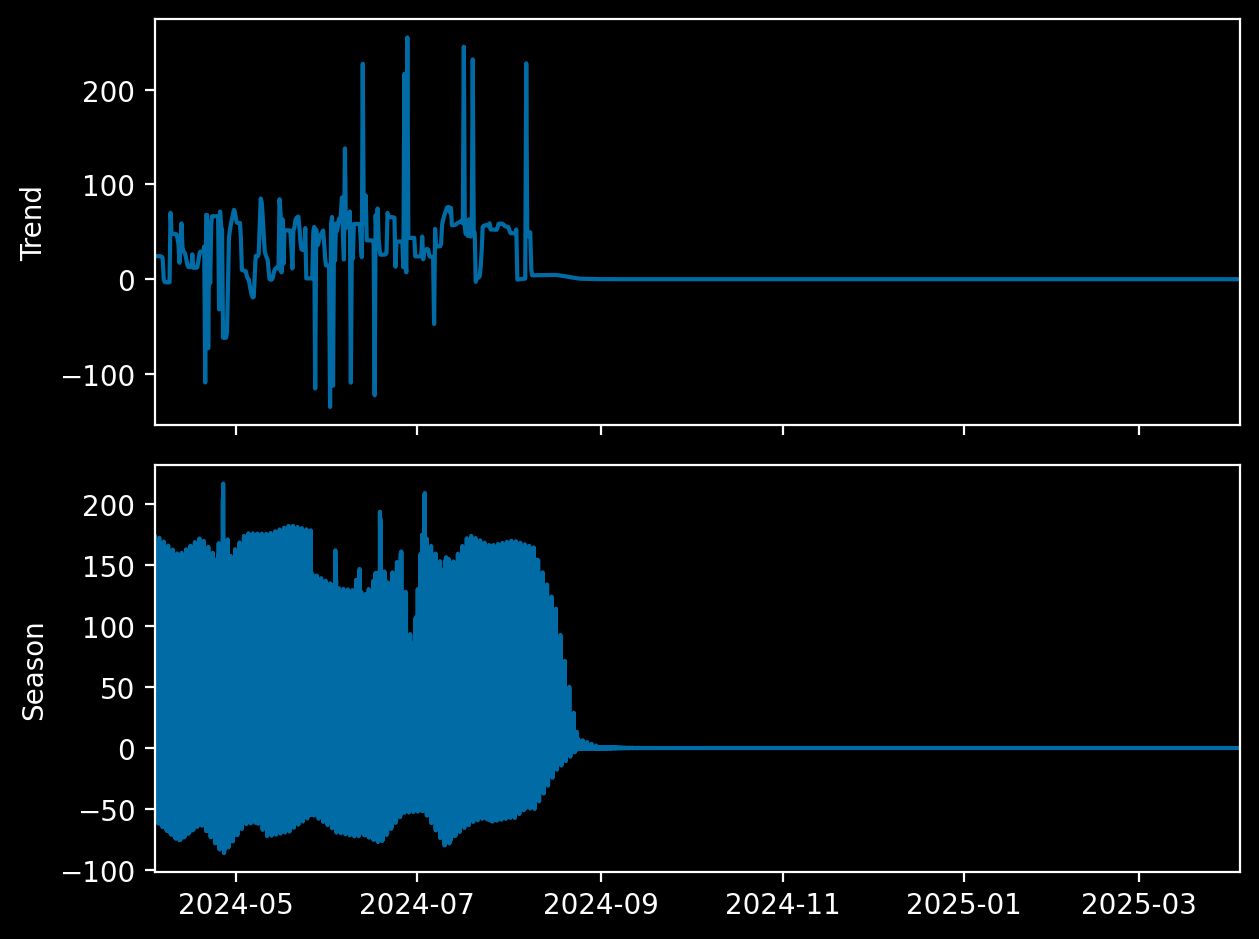

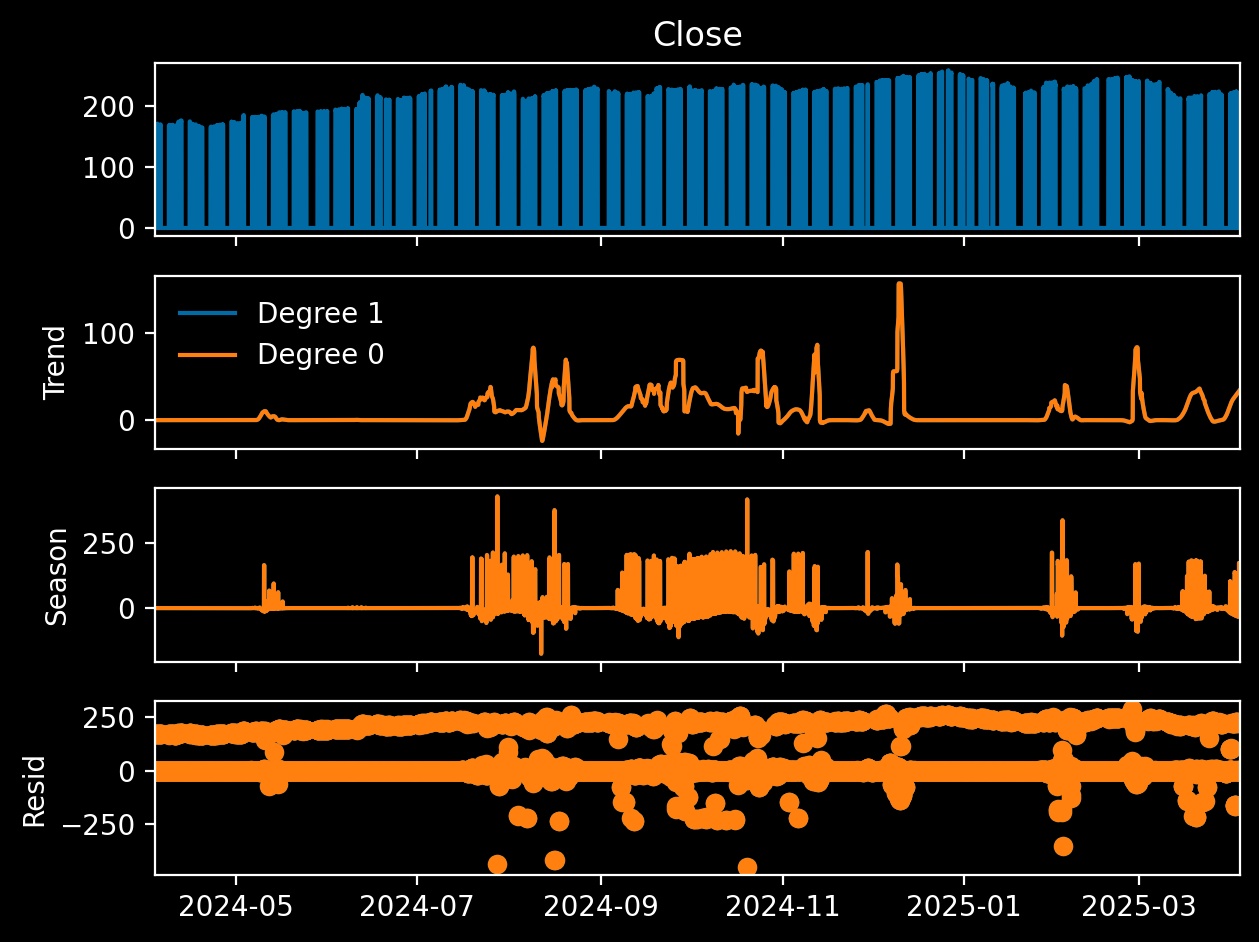

In [38]:
seasonal = period + ((period % 2) == 0)  # Ensure odd
low_pass_jump = seasonal_jump = int(0.15 * (period + 1))
trend_jump = int(0.15 * 1.5 * (period + 1))

mod = STL(
    yf_dl["Close"].dropna(),
    period=period,
    seasonal=seasonal,
    seasonal_deg=0, 
    trend_deg=0, 
    low_pass_deg=0, 
    robust=True,
    seasonal_jump=seasonal_jump,
    trend_jump=trend_jump,
    low_pass_jump=low_pass_jump,
)
%timeit mod.fit()
res = mod.fit()
fig = res.plot(observed=False, resid=False)

res_deg_0 = stl.fit()
fig = res_robust.plot()
add_stl_plot(fig, res_deg_0, ["Degree 1", "Degree 0"])

In [34]:
# Import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Check for seasonality
decomposition = seasonal_decompose(
    yf_dl["Close"].dropna(), 
    model="additive", 
    filt=None, 
    period=adf_lags_used, 
    two_sided=False, 
    extrapolate_trend="freq"
)

seasonals = decomposition.seasonal
trends = decomposition.trend

no_seasonal_trend = yf_dl["Close"] - seasonals - trends

# yf_dl["Close_no_seasonal_trend"] = no_seasonal_trend
# yf_dl.plot(y="Close")
# yf_dl.plot(y="Close_no_seasonal_trend")
decomposition


In [ ]:
6. Train time series model
7. Find the best hyperparameter values of (P, D, Q) with the smallest RMSE for building an ARIMA model<sup>[4](#myfootnote4)</sup>
8. Predict price for the next time period (Maybe two Timestamps)
9. Save timestamp, prediction and actual price to a database